# 🤖 Modeling Template
Notebook ini digunakan untuk membangun dan mengevaluasi model Machine Learning/Data Mining.

## Langkah yang disarankan:
- Pisahkan data latih dan data uji
- Latih model (misalnya: Decision Tree, Random Forest, SVM, dll.)
- Evaluasi menggunakan metrik: accuracy, precision, recall, F1-score, ROC, confusion matrix

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Baca data hasil preprocessing
df = pd.read_csv('../data/processed/dataset_final.csv')


In [10]:
pip install networkx


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 755.1 kB/s eta 0:00:02
   ---------- ----------------------------- 0.5/2.0 MB 755.1 kB/s eta 0:00:02
   --------------- ------------------------ 0.8/2.0 MB 865.6 kB/s eta 0:00:02
   -------------------- ------------------- 1.0/2.0 MB 829.8 kB/s eta 0:00:02
   -------------------- ------------------- 1.0/2.0 MB 829.8 kB/s eta 0:00:02
   ------------------------- -------------- 1.3/2.0 MB 766.2 kB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.0 MB 817.7 kB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.0 MB 817.7 kB/s eta 0:00:01
   ----------------------------

In [15]:
# Hitung frekuensi item (produk)
top_items = df['Description'].value_counts().head(100).index.tolist()

# Filter data hanya yang termasuk dalam 100 produk terbanyak
df_filtered = df[df['Description'].isin(top_items)]


In [16]:
# Group per transaksi
transactions = df_filtered.groupby('InvoiceNo')['Description'].apply(list).tolist()

# One-hot encoding
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)


In [17]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_apriori = apriori(df_encoded, min_support=0.02, use_colnames=True)
rules_apriori = association_rules(frequent_apriori, metric="confidence", min_threshold=0.3)


In [18]:
# ===== MODELING: APRIORI =====
frequent_apriori = apriori(df_encoded, min_support=0.02, use_colnames=True)
rules_apriori = association_rules(frequent_apriori, metric="confidence", min_threshold=0.3)
print(rules_apriori[['antecedents','consequents','support','confidence','lift']].head())

                         antecedents                        consequents  \
0  (PACK OF 72 RETROSPOT CAKE CASES)      (60 TEATIME FAIRY CAKE CASES)   
1      (60 TEATIME FAIRY CAKE CASES)  (PACK OF 72 RETROSPOT CAKE CASES)   
2       (ALARM CLOCK BAKELIKE GREEN)        (ALARM CLOCK BAKELIKE PINK)   
3        (ALARM CLOCK BAKELIKE PINK)       (ALARM CLOCK BAKELIKE GREEN)   
4       (ALARM CLOCK BAKELIKE GREEN)        (ALARM CLOCK BAKELIKE RED )   

    support  confidence       lift  
0  0.020457    0.320845   7.889220  
1  0.020457    0.503012   7.889220  
2  0.021069    0.425216  11.037372  
3  0.021069    0.546900  11.037372  
4  0.032829    0.662546  11.926565  


In [19]:
# ===== MODELING: FP-GROWTH =====
frequent_fp = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)
rules_fp = association_rules(frequent_fp, metric="confidence", min_threshold=0.3)
print(rules_fp[['antecedents','consequents','support','confidence','lift']].head())

                    antecedents                   consequents   support  \
0  (ALARM CLOCK BAKELIKE GREEN)   (ALARM CLOCK BAKELIKE RED )  0.032829   
1   (ALARM CLOCK BAKELIKE RED )  (ALARM CLOCK BAKELIKE GREEN)  0.032829   
2   (ALARM CLOCK BAKELIKE PINK)   (ALARM CLOCK BAKELIKE RED )  0.024683   
3   (ALARM CLOCK BAKELIKE RED )   (ALARM CLOCK BAKELIKE PINK)  0.024683   
4  (ALARM CLOCK BAKELIKE GREEN)   (ALARM CLOCK BAKELIKE PINK)  0.021069   

   confidence       lift  
0    0.662546  11.926565  
1    0.590959  11.926565  
2    0.640700  11.533298  
3    0.444322  11.533298  
4    0.425216  11.037372  


In [20]:
# ===== PERBANDINGAN HASIL =====
common_itemsets = pd.merge(frequent_apriori, frequent_fp, on='itemsets', suffixes=('_apriori', '_fp'))
common_itemsets['support_diff'] = (common_itemsets['support_fp'] - common_itemsets['support_apriori']).abs()
print(f"Itemset sama: {len(common_itemsets)}")
print(f"Itemset beda signifikan (>1%): {len(common_itemsets[common_itemsets['support_diff'] > 0.01])}")

Itemset sama: 149
Itemset beda signifikan (>1%): 0


C:\Users\M.FARHAN\AppData\Local\Temp\ipykernel_5468\3938801523.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\M.FARHAN\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


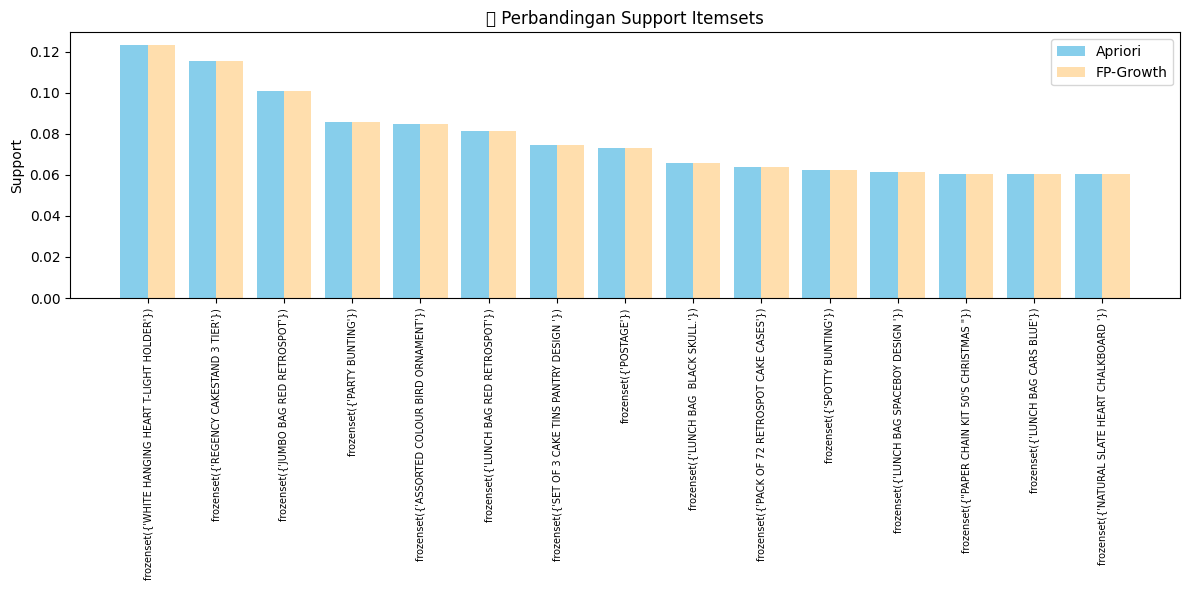

In [21]:
# ===== VISUALISASI PERBANDINGAN SUPPORT =====
top_n = 15
top_itemsets = common_itemsets.sort_values(by='support_apriori', ascending=False).head(top_n)
x = range(len(top_itemsets))
labels = top_itemsets['itemsets'].astype(str)
support_apriori = top_itemsets['support_apriori']
support_fp = top_itemsets['support_fp']

plt.figure(figsize=(12, 6))
plt.bar(x, support_apriori, width=0.4, label='Apriori', color='skyblue')
plt.bar([i + 0.4 for i in x], support_fp, width=0.4, label='FP-Growth', color='navajowhite')

for i in x:
    diff = support_fp.iloc[i] - support_apriori.iloc[i]
    if abs(diff) > 0.01:
        plt.text(i + 0.2, max(support_apriori.iloc[i], support_fp.iloc[i]) + 0.002,
                 f"{diff:+.1%}", ha='center', fontsize=7)

plt.xticks([i + 0.2 for i in x], labels, rotation=90, fontsize=7)
plt.ylabel("Support")
plt.title("📊 Perbandingan Support Itemsets")
plt.legend()
plt.tight_layout()
plt.show()



C:\Users\M.FARHAN\AppData\Local\Temp\ipykernel_5468\1361853001.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


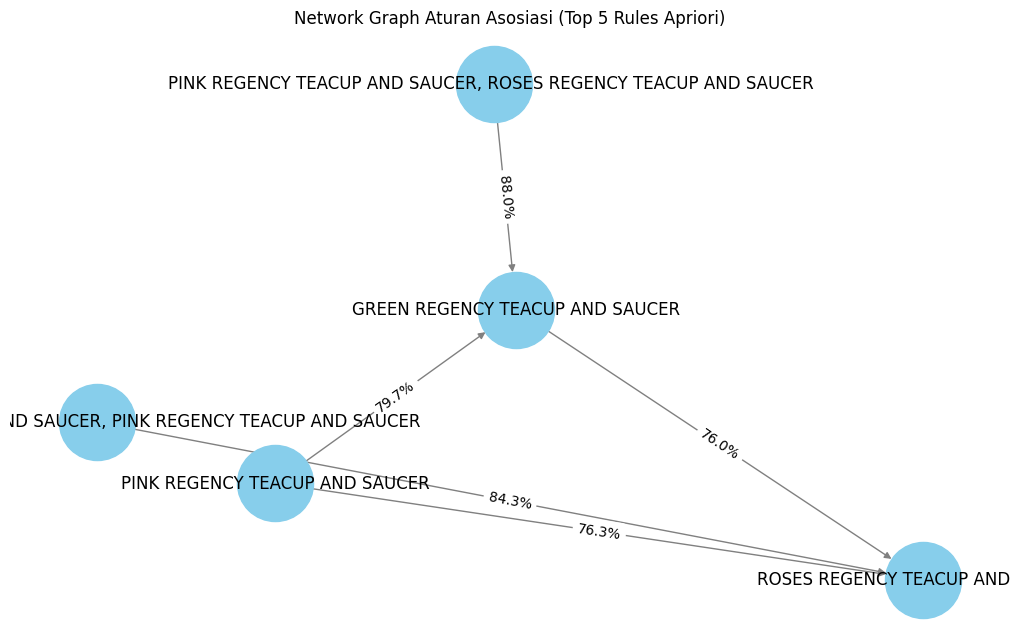

In [22]:
# ===== NETWORK GRAPH RULES (TOP 5 APRIORI) =====
G = nx.DiGraph()
top_rules = rules_apriori.sort_values(by='confidence', ascending=False).head(5)
for _, row in top_rules.iterrows():
    ant = ', '.join(row['antecedents'])
    con = ', '.join(row['consequents'])
    conf = round(row['confidence'] * 100, 1)
    G.add_edge(ant, con, weight=conf)

pos = nx.spring_layout(G, k=2)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w}%" for u, v, w in G.edges(data='weight')})
plt.title("Network Graph Aturan Asosiasi (Top 5 Rules Apriori)")
plt.tight_layout()
plt.show()